In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from collections import Counter

## Reading in the User Reviews

Var `users` is just a count of the reviews written by an individual user.


In [2]:
with open(f'./review_data/reviews_list_100.json', 'r') as f:
        file = json.load(f)

In [3]:
users = Counter()
reviews = []
for i in range(0,26900, 100):
    with open(f'./review_data/reviews_list_{i}.json', 'r') as f:
        file = json.load(f)
        reviews.extend(file) # TODO implement this part.  Forgot to scrape the actual games that the review is for
    users.update([review['reviewer'] for review in file])


### Make a df

In [4]:
rev_df = pd.DataFrame(reviews)

In [5]:
rev_df.shape

(26864, 7)

### Checking to see how many reviews were about games in my list

In [6]:
with open("games_list.json", 'r') as f:
    games_list = json.load(f)
    
game_df = pd.DataFrame(games_list)

In [7]:
rev_df = pd.merge(game_df, rev_df, left_on='name', right_on='wikiObject')
rev_df.drop(['wikiObject', 'guid_y', 'site_detail_url'] ,1, inplace=True)

In [8]:
rev_df.shape

(3608, 6)

### Get number of users who have written at least `review_thresh` reviews

In [9]:
(rev_df.reviewer.value_counts()>6).sum()

87

Well that is not a lot... 

# Game Meta Data EDA

In [15]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./game_meta_data/') if isfile(join('./game_meta_data/', f))]

In [16]:
list_of_meta = []
for file in onlyfiles:
    with open(f'./game_meta_data/{file}', 'r') as f:
        game = json.load(f)
        feature_list = ['guid', 'name', 'concepts', 'themes', 'deck', 'developers', 'publishers', 'genres', 'people']
        game_dict = {key:value for key, value in game.items() if key in feature_list}

        # convert lists to strings 
        for key, value in game_dict.items():
            if type(value) == list:
                game_dict[key] = ', '.join(value)
        list_of_meta.append(game_dict)
df = pd.DataFrame(list_of_meta)

In [18]:
df.fillna("", inplace=True)

In [19]:
df.head()

,concepts,deck,developers,genres,guid,name,people,publishers,themes
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,"Iaromil Stievenard, Anibal G. Hormeche, Sylvai...",,
1,,Zeal is an indie online ARPG developed by Lyca...,Lycanic Studios,"Action, Role-Playing, MOBA",3030-68714,Zeal,,,"Fantasy, Medieval"
2,,Vertical Drop Heroes HD is an action platformer.,Nerdook Productions,"Action, Role-Playing, Platformer",3030-48249,Vertical Drop Heroes HD,Yong Cheol Sim,,Fantasy
3,"Unreal Engine 4, PlayStation VR Support",A puzzle mystery game for PS VR.,Tarsier Studios,Puzzle,3030-57976,Statik,,,
4,,A compilation of all three Banner Saga titles.,Stoic,"Strategy, Role-Playing, Compilation",3030-68731,The Banner Saga Trilogy,,,Fantasy


### Using `concepts` to test initial EDA and to use as features for a content filter prototype

This should eventually be generalized as a function that takes in any column or one that just does all the right cols

In [13]:
df.concepts = ['' if concept == None else concept for concept in df.concepts ]

In [14]:
df['num_concepts'] = list(map(lambda x: len(x.split(',')), df.concepts))

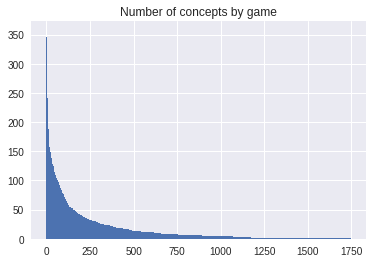

In [15]:
x = [i for i in range(df.shape[0])]
plt.bar(x, height=df.sort_values(by='num_concepts', ascending=False).num_concepts, width=1)
plt.title('Number of concepts by game')

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
bow = cvec.fit_transform(df.concepts)


contents_df  = pd.DataFrame(bow.todense(),
                   columns=cvec.get_feature_names())
contents_df.head()

,,180 degree turn,2.5d,21:9 ultrawide support,21st annual d.i.c.e. awards,285 code 6,2d,2d depth attack,3 round burst,360 flip,...,zombie pigmen,zombie protagonist,zombie virus,zombrex,zoning character,zoom,zoom platform,zooming out to orbit,zooming to platform pathway,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Now I am going to convert the previous chunk of code into a function so I can use it on other features like `genres` or `developers`

In [21]:
def split_features(df, col):
    df[col] = ['AAAA' if entry == None else entry for entry in df[col] ]
    cvec = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
    bow = cvec.fit_transform(df[col])
    ret_df  = pd.DataFrame(bow.todense(),
                       columns=cvec.get_feature_names())
    return ret_df

In [18]:
df.loc[22, :]

concepts        PlayStation Trophies, First-Person Perspective...
deck            A completely new game designed from the ground...
developers                                          SUPERHOT Team
genres                                                           
guid                                                   3030-54217
name                                                  Superhot VR
publishers                                                       
themes                                                           
num_concepts                                                   11
Name: 22, dtype: object

In [24]:
split_features(df, 'people').head()

,,bart wiltenburg,eric beyhl,jacek kwiecień,kiomi ōshima,sybille adrien,xavier thomas,peter chapman,takuya sakai,2joe90,...,özlem sagbili,østnorsk filmsenter,øystein skadsem,øystein stokkan,łukasz bieńko,łukasz darmochwał,łukasz mazurkiewicz,łukasz pala,łukasz tywoniak,łukasz wyrostek
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## lets drop all the features that apply to less than 5 games

In [20]:
contents_df.shape

(1746, 3767)

In [21]:
thresh = 5
cols_to_drop = []
for col in contents_df.columns:
    try:
        if contents_df[col].value_counts()[0] >=contents_df.shape[0]-thresh:
            cols_to_drop.append(col)
    except: 
        print(col)


In [22]:
len(cols_to_drop)

2580

In [23]:
contents_df.drop(cols_to_drop, axis=1, inplace=True)
contents_df.shape

(1746, 1187)

## Doing the same, but with the actual games

In [24]:
rows_to_drop = []
for ind in contents_df.T.columns:
    if contents_df.T.get(ind).sum() < thresh:
        rows_to_drop.append(ind)

In [25]:
len(rows_to_drop)

815

In [26]:
contents_df.drop(rows_to_drop, axis = 0, inplace=True)
contents_df.shape

(931, 1187)

In [37]:
merged = pd.merge(df, contents_df, left_index=True, right_index=True, )

In [38]:
merged.shape

(931, 1196)

In [39]:
merged.head()

,concepts,deck,developers,genres,guid,name,publishers,themes,num_concepts,,...,xbox one backwards compatibility,xbox one controller support for pc,xbox one x enhanced,xbox play anywhere,xfire,year in the title,young protagonist,zombie,zoning character,zoom
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,,,11,0,...,0,0,0,0,0,0,0,0,0,0
6,"Double Jump, Teleportation, Achievements, Boss...",The third entry in the Super Mario Bros inspir...,Black Forest Games,Platformer,3030-39484,Giana Sisters: Twisted Dreams,,Fantasy,78,0,...,0,0,0,0,0,0,0,0,0,0
11,"Ninja, Anthropomorphism, Crossover, Sexualized...",A crossover Warriors game from Omega Force and...,Omega Force,Action,3030-55468,Warriors All-Stars,,"Fantasy, Alternate Historical",8,0,...,0,0,0,0,0,0,0,0,0,0
12,"Steam, Digital Distribution, Indie, PlayStatio...",We Are Doomed is a frantic shoot-em-up in a vi...,Vertex Pop,Shoot 'Em Up,3030-45908,We Are Doomed,,,7,0,...,0,0,0,0,0,0,0,0,0,0
14,"Combo, Achievements, Health, Heads Up Display,...",The third major installment of the Street Figh...,"Dimps Corporation, Capcom",Fighting,3030-43241,Ultra Street Fighter IV,,Martial Arts,92,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
merged.set_index(['name'], inplace=True)

In [41]:
merged.drop(['concepts', 'deck', 'developers', 'genres', 'themes', 'publishers','num_concepts', '', 'guid'], 1, inplace=True)

In [42]:
merged.shape

(931, 1186)

In [43]:
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

In [44]:
sparse_content = sparse.csr_matrix(merged)

In [45]:
distances = pairwise_distances(sparse_content, metric='cosine')

In [46]:
distance_df = pd.DataFrame(distances, index=merged.index, columns=merged.index)
distance_df.head()

name,Kill the Bad Guy,Giana Sisters: Twisted Dreams,Warriors All-Stars,We Are Doomed,Ultra Street Fighter IV,Arcania: Gothic 4,Lichdom: Battlemage,The King of Fighters Collection: The Orochi Saga,Alien Shooter,JumpJet Rex,...,LEGO Marvel Super Heroes 2,Sword Art Online: Hollow Fragment,Alienation,World Heroes 2 JET,Mystereet F: Tantei-tachi no Curtain Call,Hotline Miami 2: Wrong Number,The Magic Circle,Gran Turismo Sport,Mighty No. 9,Sonic Forces
name,,,,,,,,,,,,,,,,,,,,,
Kill the Bad Guy,0.000000,0.736178,1.000000,0.772079,0.709618,0.875753,0.654143,0.922150,0.899496,0.844300,...,1.000000,0.865160,0.932580,1.000000,1.000000,0.944011,0.912961,1.0,0.729235,1.000000
Giana Sisters: Twisted Dreams,0.736178,0.000000,1.000000,0.858263,0.819421,0.879810,0.827938,0.967725,0.916667,0.838626,...,0.966592,0.944098,0.888197,1.000000,1.000000,0.907152,0.963916,1.0,0.708141,0.903175
Warriors All-Stars,1.000000,1.000000,0.000000,1.000000,0.954498,1.000000,1.000000,0.902410,1.000000,1.000000,...,0.898985,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
We Are Doomed,0.772079,0.858263,1.000000,0.000000,0.863495,0.896165,0.653156,0.902410,0.874012,0.902410,...,1.000000,0.830969,0.830969,1.000000,1.000000,0.789441,0.672673,1.0,0.796347,1.000000
Ultra Street Fighter IV,0.709618,0.819421,0.954498,0.863495,0.000000,0.884246,0.723816,0.875666,0.959871,0.875666,...,0.967826,0.946162,0.919243,0.833055,0.950853,0.932935,0.895743,1.0,0.827024,1.000000


This throws some errors when you request a dropped game

In [47]:
search = 'Far Cry'
for title in df.loc[df['name'].str.contains(search), 'name'].values:
    if title in distance_df.columns:
        print(title)
        print()
        print('Similar Games:')
        print(distance_df[title].sort_values()[1:11])
        print()
        print()


Far Cry 4

Similar Games:
name
Far Cry 3                               0.474328
Assassin's Creed Unity                  0.640078
Grand Theft Auto V                      0.645396
Assassin's Creed Origins                0.650993
Metal Gear Solid V: The Phantom Pain    0.651397
Assassin's Creed IV: Black Flag         0.656691
Watch Dogs                              0.665481
Call of Duty: Ghosts                    0.672383
Middle-earth: Shadow of Mordor          0.686693
Dying Light                             0.692233
Name: Far Cry 4, dtype: float64


Far Cry 3

Similar Games:
name
Far Cry 4                               0.474328
Assassin's Creed Origins                0.541962
Grand Theft Auto V                      0.550388
Metal Gear Solid V: The Phantom Pain    0.615854
Assassin's Creed IV: Black Flag         0.625602
Call of Duty: Ghosts                    0.636869
Saints Row IV                           0.638114
Call of Duty 4: Modern Warfare          0.640223
Fallout 4             

In [48]:
merged.loc['5 Star Wrestling',merged.loc['5 Star Wrestling', :]==1]

digital distribution    1
grapple                 1
language selection      1
loading screens         1
options menu            1
playstation trophies    1
taunting                1
Name: 5 Star Wrestling, dtype: int64

In [49]:
merged.loc['Adventure Pop',merged.loc['Adventure Pop', :]==1]

achievements            1
digital distribution    1
free to play            1
loading screens         1
options menu            1
playstation trophies    1
tutorial                1
Name: Adventure Pop, dtype: int64